In [6]:
import time
import datetime
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
from copy import deepcopy
import socket
import os
import re #Searches strings
import operator
from collections import OrderedDict #Allows the use of Ordered Dictionaries
from difflib import SequenceMatcher #Allows to quickly compare two strings to see how similar they are

#Desired energy
target_energy = 240 #Target energy in microjoules
#Desired tolerance
tolerance = 0.025 #2.5% plus or minus

interpolation_data = OrderedDict()
#Measured energy values at different attenuator degrees
interpolation_data[0]  = 187
interpolation_data[2]  = 192
interpolation_data[4]  = 205
interpolation_data[6]  = 226
interpolation_data[8]  = 254
interpolation_data[10] = 310
interpolation_data[12] = 360
interpolation_data[14] = 420
interpolation_data[16] = 480
interpolation_data[18] = 560
interpolation_data[20] = 650
#Power in the dragonview program at the time of measurement
interpolation_data['power'] = 2.01

#FWHM shift estimations, if oscillator stable then make start = end
start_FWHM = 58.0 #Starting Full Width Half maximum value used in the process in nm
end_FWHM = 55.0 #likely end value for Full Width Half maximum at the end of the process in nm
duration = 6 #Duration of the process in hours. Note: This is an exponential curve, ~78% of the change will happen after
                # ~33% of the time has elapsed

def sine_func(x, a, b, c):
    """
    Function used to find the best fit parameters
    Requires
    * x (float): The angle in degrees
    * a,b,c (float): Curve fitting parameters
    
    Returns:
    * result (float): Result of the operation a + b * np.sin(((x-c)*np.pi*4/180))
    """
    
    result = a + b * np.sin(((x+c)*np.pi*4/180))
    return result


def find_sine_params(interpolation_data):
    """
    Function to find the best fit params for the sine_func
    Requires:
    * interpolation_data (OrderedDict): keys correspond to the angle and values correspond to experimental data obtained.
    The entry for 'power' corresponds to the average of the power at the start and end of the measurement of the
    experimental data
    
    Returns:
    popt (numpy array): Contains the parameters found by curve fitting
    pcov (numpy array): Estimated covariance of the parameters
    """
    
    count = 0
    x_vals = np.zeros(11)
    y_vals = np.zeros(11)

    for keys, values in interpolation_data.items():
        if keys != 'power':
            x_vals[count] = float(keys)
            y_vals[count] = float(values)
        count += 1
    print(y_vals)
    popt, pcov = curve_fit(sine_func, 
                x_vals, 
                y_vals, 
                #p0 = (0, 0, 0),
                maxfev = 10000,
                #lmbounds = ([0.,0., 0.], [y_vals[0] * 1.20, y_vals[-1] * 1.20, 45.0]),
                method = 'lm') #lm trf dogbox
    plot_vals = np.linspace(0, 45, 46)
    plt.plot(plot_vals, sine_func(plot_vals, *popt), 'r-', label='Fitted curve') 
    plt.plot(x_vals, y_vals, 'b.', label='Measured data')
    plt.xlabel('Attenuator degrees')
    plt.ylabel('Measured energy (uJ)')
    plt.legend()
    plt.show()
    print("a = {}, b = {}, c = {}".format(*popt))
    return (popt, pcov)


def find_shift(start_FWHM, curr_FWHM, att_angle):
    """
    Finds relative change in energy due to FWHM change
    Requires:
    * start_FWHM (float): This is the starting Full Width Half Maximum of the pulse (i.e at the start of the process)
    * curr_FWHM (float): This is the current FWHM
    * att_angle (float): Attenuator angle
    
    Returns:
    result (float): Returns a number between 0-1, with the ratio of change to be used to correct energy values
    """
    a_coefs = np.array([0.00264568525, -0.00876555616, 23.2104304])
    b_coefs = np.array([-0.31074797, 1.0295546, 23.21042891])
    c_coefs = np.array([9.09710449, -29.38978833, 23.50026379])
    
    a_val = a_coefs[0] + a_coefs[1]*np.sin((att_angle+a_coefs[2])*np.pi/45.0)
    b_val = b_coefs[0] + b_coefs[1]*np.sin((att_angle+b_coefs[2])*np.pi/45.0)
    c_val = c_coefs[0] + c_coefs[1]*np.sin((att_angle+c_coefs[2])*np.pi/45.0)
    
    start_val = a_val * np.power(start_FWHM,2) + b_val * start_FWHM + c_val
    curr_val = a_val * np.power(curr_FWHM,2) + b_val * curr_FWHM + c_val
    
    result = curr_val / start_val
    return result
    
def findx(target_energy, factor, a,b,c):
    """
    Finds the attenuator value from a curve fitted sine function and returns it with 1 decimal place
    Requires:
    * target_energy (float): This is the energy we wish to maintain
    * factor (float): The relation between the power at which the curve was fitted vs current power 
    (i.e curr_pow/original_pow)
    * a, b, c (float): Curve fitting parameters found previously
    
    Returns:
    all_att_angles[att_val] (float): Returns the new attenuator value
    """
    
    all_att_angles = np.linspace(0, 45, 451) #Creates an array with all att. angles
    target_val = np.full(451, target_energy) #Creates an array of 451 elements with the target_val
    corrected_results = sine_func(all_att_angles, a, b, c) * factor #Creates an array with corrected energy values
    corrected_results = np.abs(corrected_results - target_val) #attempts to find the value closest to the target
    att_val = np.argmin(corrected_results) #returns the position of the lowest value to use in all_att_angles
    return all_att_angles[att_val]

def return_time_elapsed(start_time):
    """
    Returns the time passed since start_time
    Requires:
    start_time (float): The time as obtained from time.time() at the beginning of the process
    
    Returns:
    result (float): The time elapsed in seconds
    """
    time_now = time.time()
    result = time_now-start_time
    return result

def findx2(target_energy, factor, start_FWHM, curr_FWHM, a,b,c):
    """
    Finds the attenuator value from a curve fitted sine function and returns it with 1 decimal place
    Requires:
    * target_energy (float): This is the energy we wish to maintain
    * factor (float): The relation between the power at which the curve was fitted vs current power 
    (i.e curr_pow/original_pow)
    * a, b, c (float): Curve fitting parameters found previously
    
    Returns:
    all_att_angles[att_val] (float): Returns the new attenuator value
    """
    
    all_att_angles = np.linspace(0, 45, 451) #Creates an array with all att. angles
    target_val = np.full(451, target_energy) #Creates an array of 451 elements with the target_val
    FWHM_factors = find_shift(start_FWHM, curr_FWHM, all_att_angles) * factor 
    corrected_results = sine_func(all_att_angles, a, b, c) * FWHM_factors#Creates an array with corrected energy values
    corrected_results = np.abs(corrected_results - target_val) #attempts to find the value closest to the target
    att_val = np.argmin(corrected_results) #returns the position of the lowest value to use in all_att_angles
    return all_att_angles[att_val]

def find_curr_FWHM(curr_time, start_FWHM, end_FWHM, duration):
    """
    This function determines the approximate value of FWHM
    Requires:
    curr_time(float): The time elapsed in seconds
    start_FWHM (float): The starting value of Full Width Half Maximum in nm
    end_FWHM (float): The predicted end value of the FWHM in nm
    duration (float): Duration of the proces in hours
    
    Returns:
    result (float): Returns the predicted current FWHM value
    """
    
    pc_dur = curr_time/(duration*3600)
    val = 4.5 * pc_dur
    d_FW = start_FWHM - end_FWHM
    FW_s = start_FWHM
    result = FW_s - (d_FW - d_FW * np.exp(-val))
    return result
    
def searcher(string):
    """
    Finds any file with the .csv extension, requires a string to search
    Requires:
    * string (string): Object in which to search
    
    Returns:
    * search results (string): Returns results that match the search criteria
    """
    
    file = re.compile(r'^[^~$].+\.csv')
    return file.search(string)


def file_adder(directory):
    """
    Returns a list with all the csv files in the directory
    Requires:
    * directory (string): Path in which to search for files
    
    Returns:
    * files (list): List with all the paths + filenames 
    """
    
    files =[]
    for elements in os.listdir(directory):
        if searcher(elements):
            files.append(os.path.join(directory, elements))
    return files


def file_get():
    """
    Opens the first .csv file on this directory
    Requires:
    Nothing
    
    Returns:
    * file_handle (file object): File object, open in read mode
    """
    
    curr_dir = os.getcwd()
    target_dir = curr_dir
    csv = file_adder(target_dir)[0]
    print("Opening file: {}".format(csv))
    file_handle = open(csv, "r")
    return file_handle


def line_get(file_handle):
    """
    Returns a generator that endlessly reads a file while occupying constant memory. requires file_handle(file object)
    Requires:
    * file_handle (file object): Requires an open file in read mode
    
    Returns:
    * line (generator object): Returns an endless generator that provides lines each time the next() method it's called
    """

    file_handle.seek(0,2) #Change to 0,2 if only newest lines are of interest or 0,1 if we want to read from the beginning
    while True:
        line = file_handle.readline()
        if not line:
            time.sleep(10)
            continue
        yield line

        
def packet(obj):
    """
    Converts an obj to bytes in order to send them via TCP/IP, requires obj (any type compatible with str() function)
    Requires:
    * obj (any type except None): Takes any type of object that can be converted to string
    
    Returns:
    * obj (bytes): Returns the input object, converted to bytes
    """
    
    obj = str(obj)
    return bytes(obj, 'utf-8')


def create_client(ip_addr, port):
    """
    Creates a connection with the specified server. Server must be listening for connections
    Requires:
    * ip_addr (string) 
    * port (integer)
    
    Returns:
    s (connection): Returns a TCP_IP connection of type SOCK_STREAM
    """
    
    TCP_IP = ip_addr
    TCP_PORT = port
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.connect((TCP_IP, TCP_PORT))
    return s


def process_log(line):
    """
    Processes the csv file, splitting each member into a list and removing spaces and newline characters.
    Requires:
    * line (string)
    
    Returns:
    * proc_data (list): A list of values that were split around the separator
    """
    
    proc_data = line.split(',')
    for i in range(0, len(proc_data), 1):
        proc_data[i] = proc_data[i].strip(' ').strip('\n')
    return proc_data


def return_datetime():
    """
    Provides a string of the date and time in the format YYYY/MM/DD HH:MM:SS
    Requires:
    Nothing
    
    Returns:
    date_time (string): Returns the date and time in the following format YYYY/MM/DD HH:MM:SS
    """
    
    date_time = datetime.datetime.now().strftime('%Y/%m/%d %H:%M:%S')
    return date_time


def convert_to_float(string, interpolation_data):
    """
    Attempts to convert a string to a floating point, if it fails, then returns the value of power measured originally
    Requires:
    * string (string): A string to attempt to conver to float
    * interpolation_data (dictionary): Experimental data measured before starting the process
    """
    
    try:
        output = float(string)
        return output
    except:
        output = interpolation_data['power']
        return output


def start_monitor(ip_addr, port, inter_data, target_ener, start_FWHM, end_FWHM, duration, BUFFER_SIZE = 32):
    """
    Continuously reads power measurement and transmits the attenuator values to the server
    Requires:
    ip_addr (string)
    port (integer)
    inter_data (dictionary)
    target_ener (float)
    optional BUFFER_SIZE (integer)
    
    Returns:
    Nothing   
    """
    
    try:
        start_time = time.time()
        original_power = inter_data['power']
        prev_power = inter_data['power'] #set the starting power as the power measured
        popt = find_sine_params(inter_data)[0]
        #att_value = interpolate(inter_data, target_ener, prev_power) #set the starting att_value
        
        curr_time = return_time_elapsed(start_time)
        curr_FWHM = find_curr_FWHM(curr_time, start_FWHM, end_FWHM, duration)
        att_value = findx2(target_ener, 1.0, start_FWHM, curr_FWHM, *popt)
        #findx(target_ener, 1.0, *popt) #Find x with current power
        
        file_handle = file_get() #Open the file
        generator = line_get(file_handle) #Create the endless line generator
        
        s = create_client(ip_addr, port) #Create a client TCP/IP connection
        for lines in generator: #Start getting the lines from the generator
            #time.sleep(5) #test only: sleep for 5 seconds if not testing, disable
            line = process_log(lines) #Separate the lines by commas into a list
            new_power = convert_to_float(line[3],interpolation_data) #convert the power value to floating point
            #Clause to handle the cases where the seed laser/pump laser are disconnected
            if (new_power != prev_power and prev_power != 0 and new_power != 0):
                #If the value changes more than tolerance then change the attenuator val
                if np.abs(np.abs((new_power-prev_power)/prev_power)) > tolerance: #if change is  > tol adjust att
                    factor = new_power/original_power
                    #att_value = interpolate(inter_data, target_ener, new_power) #Old interpolation
                    #att_value = findx2(target_ener, factor, *popt) #New sine based interpolation
                    curr_time = return_time_elapsed(start_time)
                    curr_FWHM = find_curr_FWHM(curr_time, start_FWHM, end_FWHM, duration)
                    att_value = findx2(target_ener, factor, start_FWHM, curr_FWHM, *popt)
                    prev_power = new_power
            #Print the values read from the csv file + the att_value sent to the server and the time it was sent
            aval = "{0:.1f}".format(att_value)
            string = "log_time = {}, log_power = {} W, att_value_sent = {}, sent {}".format(line[0], line[3], 
                                                                                        aval, return_datetime())
            print(string, end = '\n') #'\r' means return carriage. Overwrites the same line
            s.send(packet(att_value)) #Send the att_value in bytes to the server
            data = s.recv(BUFFER_SIZE) #Waits for server response, this is necessary to prevent the client 
                        #from sending the next packet before the server is ready
    except:
        print("\nExcept clause entered: closing connections...")
        s.close() #Closes connections in the case of an exception
    
    return


    

[ 187.  192.  205.  226.  254.  310.  360.  420.  480.  560.  650.]


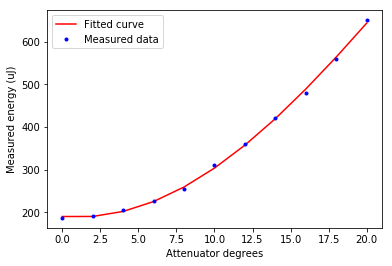

a = 786.7188975175675, b = -597.825850863058, c = 831.5263843717028
Opening file: /home/eduardo/Desktop/Programming/Python/TCP-IP test/2017_10_20_1042_DragonView Data.csv
log_time = Time, log_power = Power (W) W, att_value_sent = 6.9, sent 2017/10/25 13:27:30
log_time = 10/20/2017 11:28:11.973, log_power = 1.636 W, att_value_sent = 9.6, sent 2017/10/25 13:27:37
log_time = 10/20/2017 11:28:21.972, log_power = 1.637 W, att_value_sent = 9.6, sent 2017/10/25 13:27:43
log_time = 10/20/2017 11:28:31.988, log_power = 2.178 W, att_value_sent = 5.7, sent 2017/10/25 13:27:48
log_time = 10/20/2017 11:28:41.996, log_power = 2.191 W, att_value_sent = 5.7, sent 2017/10/25 13:27:55
log_time = 10/20/2017 11:28:52.007, log_power = 2.023 W, att_value_sent = 6.8, sent 2017/10/25 13:28:00
log_time = 10/20/2017 11:28:21.972, log_power = 1.637 W, att_value_sent = 9.6, sent 2017/10/25 13:28:06
log_time = 10/20/2017 11:29:02.016, log_power = 2.175 W, att_value_sent = 5.8, sent 2017/10/25 13:28:12
log_time = 1

In [54]:
#adapted from: https://wiki.python.org/moin/TcpCommunication
#clientside

#Needs to be stopped manually
start_monitor('127.0.0.1', 13539, interpolation_data, target_energy, start_FWHM, end_FWHM, duration) 

In [55]:
print(type(time.time()))

<class 'float'>


[ 187.  192.  205.  226.  254.  310.  360.  420.  480.  560.  650.]


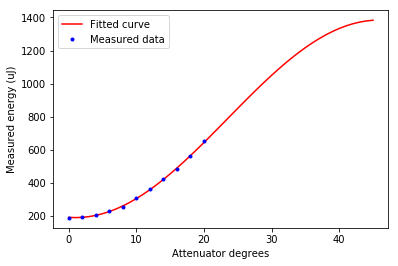

a = 786.7188975175675, b = -597.825850863058, c = 831.5263843717028


In [9]:
popt, pcov = find_sine_params(interpolation_data)


In [11]:
print(sine_func(10, *popt))
print(sine_func(20, *popt))
print(sine_func(30, *popt))
print(sine_func(40, *popt))

303.715702708
643.160450642
1049.77779134
1333.30695205
